Installing libraries...
  Preparing metadata (setup.py) ... done
Installation complete. If this is the first run, please restart the runtime now.
Using device: cuda

Loading models...
Models loaded successfully.

Please upload the image you want to process.


Saving dog.jpg to dog (7).jpg
Image 'dog (7).jpg' uploaded successfully.

Segmentation complete. Displaying result.


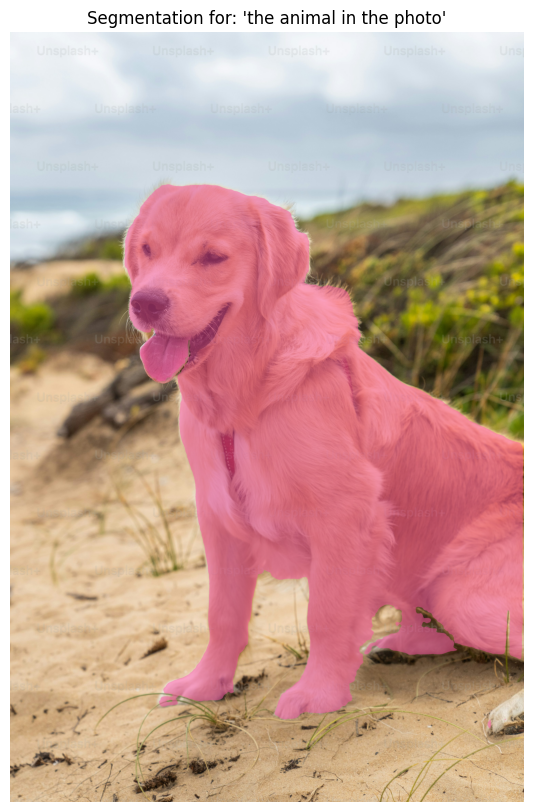

In [7]:
# ==============================================================================
# Q2 Solution using Grounding DINO + SAM (Robust Manual Post-Processing)
# ==============================================================================

# --- 1. INSTALLATION & UPGRADE ---
print("Installing libraries...")
!pip install -q -U torch supervision transformers Pillow
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib
print("Installation complete. If this is the first run, please restart the runtime now.")

# --- 2. IMPORTS & SETUP ---
import torch
import supervision as sv
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# --- 3. LOAD MODELS ---
def load_models():
    # Grounding DINO
    detection_model_id = "IDEA-Research/grounding-dino-tiny"
    detection_processor = AutoProcessor.from_pretrained(detection_model_id)
    detection_model = AutoModelForZeroShotObjectDetection.from_pretrained(detection_model_id).to(device)

    # SAM
    model_type = "vit_b"
    SAM_CHECKPOINT = f"sam_{model_type}.pth"
    if not os.path.exists(SAM_CHECKPOINT):
        print(f"Downloading SAM {model_type} checkpoint...")
        url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
        urllib.request.urlretrieve(url, SAM_CHECKPOINT)
    sam = sam_model_registry[model_type](checkpoint=SAM_CHECKPOINT).to(device)
    predictor = SamPredictor(sam)

    return detection_processor, detection_model, predictor

print("\nLoading models...")
try:
    detection_processor, detection_model, predictor = load_models()
    print("Models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")


# --- 4. UPLOAD IMAGE ---
print("\nPlease upload the image you want to process.")
uploaded = files.upload()
if uploaded:
    IMAGE_PATH = list(uploaded.keys())[0]
    image_pil = Image.open(IMAGE_PATH).convert("RGB")
    print(f"Image '{IMAGE_PATH}' uploaded successfully.")

    # --- 5. DEFINE PROMPT & RUN PIPELINE ---
    text_prompt = "the animal in the photo" # Change this to describe the object

    # Pre-process inputs
    inputs = detection_processor(images=image_pil, text=text_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = detection_model(**inputs)

    # Manual Post-Processing to avoid version errors
    logits = outputs.logits.cpu().sigmoid()[0]
    boxes = outputs.pred_boxes.cpu()[0]
    box_threshold = 0.2

    filt_mask = logits.max(dim=1)[0] > box_threshold

    if filt_mask.sum() == 0:
         print("\nFailed to detect any objects. Try a different prompt or lower the threshold.")
    else:
        boxes_filt = boxes[filt_mask]
        logits_filt = logits[filt_mask]

        best_box_idx = logits_filt.max(dim=0)[1][0]
        final_box_unscaled = boxes_filt[best_box_idx]

        # Un-normalize the box from [0,1] center_x, center_y, w, h to [x1, y1, x2, y2] format
        img_size = torch.tensor([image_pil.width, image_pil.height])
        x_c, y_c, w, h = final_box_unscaled.unbind(0)
        final_box = torch.stack([(x_c - 0.5 * w) * img_size[0], (y_c - 0.5 * h) * img_size[1],
                                (x_c + 0.5 * w) * img_size[0], (y_c + 0.5 * h) * img_size[1]])

        # --- 6. REFINE WITH SAM ---
        predictor.set_image(np.array(image_pil))
        masks, _, _ = predictor.predict(
            box=final_box.cpu().numpy(),
            multimask_output=False,
        )
        final_mask = masks[0]

# --- 7. VISUALIZE RESULT (Absolutely Final Version) ---
print("\nSegmentation complete. Displaying result.")

# Add a "batch" dimension to the mask.
final_mask_batched = final_mask[np.newaxis, ...].astype(bool)

# Creating the Detections object manually.
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=final_mask_batched),
    mask=final_mask_batched
)

# Creating the annotator, telling it to color by index since we don't have class IDs.

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = mask_annotator.annotate(
    scene=np.array(image_pil),
    detections=detections
)

# Displaying the final annotated image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(annotated_image)
ax.set_title(f"Segmentation for: '{text_prompt}'")
ax.axis('off')
plt.show()